In [ ]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [ ]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


## Visualize peak spatial frequency preferences

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from tqdm import tqdm
from utils import generate_grating, get_feature_map_responses, measure_spatial_frequencies
from model import AlexNetSup

# Define the color schemes
dataset_colors = {
    'Toybox-12': ("#d8a6a6", "#a00000"),
    'Toybox-360': ("#9fc8c8", "#1f6f6f"),
    'ImageNet-12': ("#5689c8", "#082a54"),
    'FaceScrub': ("#d1adef", "#57039c"),
    'ImageNet-100': ("#f5d76e", "#a67300")
}

def load_spatial_freq_data(model_dir, num_classes):
    """
    For a given model directory and number of classes, load checkpoints at various epochs,
    measure the peak spatial frequency for each convolutional layer, and return a dictionary.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AlexNetSup(num_classes=num_classes).to(device)
    model.eval()

    all_epoch_results = {}
    epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    for epoch in epochs:
        checkpoint_path = os.path.join(model_dir, f"model_checkpoint_epoch{epoch}.pth")
        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint not found: {checkpoint_path}")
            continue

        checkpoint = torch.load(checkpoint_path, map_location=device)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"])
        else:
            model.load_state_dict(checkpoint)

        # Measure spatial frequencies for all hooked layers.
        peak_sf_dict = measure_spatial_frequencies(model, device)
        all_epoch_results[epoch] = peak_sf_dict

    return all_epoch_results

def plot_spatial_freq_evolution(all_epoch_results, dataset='Toybox-12'):
    sigma_labels = {
        20: r'$\sigma=8$',
        40: r'$\sigma=4$',
        60: r'$\sigma=2$',
        80: r'$\sigma=1$',
        100: r'$\sigma=0$'
    }
    # Update the layer names to match the AlexNetSup architecture.
    # These correspond to the conv layers in the feature extractor.
    layer_names = [
        "features.0",
        "features.3",
        "features.6",
        "features.8",
        "features.10",
    ]
    layer_titles = {
        "features.0": "Conv 1",
        "features.3": "Conv 2",
        "features.6": "Conv 3",
        "features.8": "Conv 4",
        "features.10": "Conv 5",
    }

    # Select the color pair for the dataset; default to 'Toybox-12' if not found
    color_light, color_dark = dataset_colors.get(dataset, dataset_colors['Toybox-12'])
    cmap = LinearSegmentedColormap.from_list("custom_cmap", [color_light, color_dark])

    epochs = sorted(all_epoch_results.keys())
    epoch_colors = [cmap(i / (len(epochs)-1)) for i in range(len(epochs))]

    fig, axes = plt.subplots(1, len(layer_names), figsize=(2.5 * len(layer_names), 3), sharey=True)
    if len(layer_names) == 1:
        axes = [axes]

    for i, lname in enumerate(layer_names):
        ax = axes[i]
        for idx, epoch in enumerate(epochs):
            # It is assumed that measure_spatial_frequencies returns a dict with keys that match the above layer names.
            peak_sfs = all_epoch_results[epoch].get(lname, [])
            if len(peak_sfs) == 0:
                continue
            sorted_peaks = np.sort(peak_sfs)
            ax.plot(sorted_peaks, label=sigma_labels[epoch], color=epoch_colors[idx])
        ax.set_title(layer_titles[lname], fontsize=12)
        ax.set_xlabel("Feature map")
        if i == 0:
            ax.set_ylabel("Peak Spatial Frequency\n(cycles/image)")
            ax.legend(frameon=False, loc='upper left')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
import pickle

output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies"
os.makedirs(output_dir, exist_ok=True)

### Peak spatial frequency preferences of blur Toybox-12 blurry-to-clear trained CNN

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"

toybox12_results = load_spatial_freq_data(model_dir, 12)

with open(os.path.join(output_dir, "toybox12_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(toybox12_results, f)

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_clear_100_epochs"

toybox12_clear_results = load_spatial_freq_data(model_dir, 12)

with open(os.path.join(output_dir, "toybox12_clear_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(toybox12_clear_results, f)

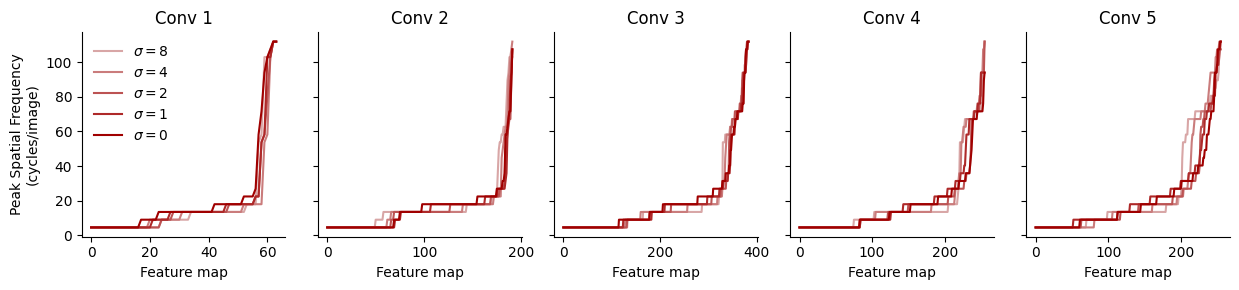

In [ ]:
plot_spatial_freq_evolution(toybox12_results, 'Toybox-12')

### Peak spatial frequency preferences of Toybox-360 blurry-to-clear trained CNN

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"

toybox360_results = load_spatial_freq_data(model_dir, 360)

with open(os.path.join(output_dir, "toybox360_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(toybox360_results, f)

# plot_spatial_freq_evolution(toybox360_results, 'Toybox-360')

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_clear_100_epochs"

toybox360_clear_results = load_spatial_freq_data(model_dir, 360)

with open(os.path.join(output_dir, "toybox360_clear_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(toybox360_clear_results, f)

### Peak spatial frequency preferences of FaceScrub blurry-to-clear trained CNN

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"

facescrub_results = load_spatial_freq_data(model_dir, 297)
#plot_spatial_freq_evolution(facescrub_results, 'FaceScrub')

with open(os.path.join(output_dir, "face_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(facescrub_results, f)

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_clear_100_epochs"

facescrub_clear_results = load_spatial_freq_data(model_dir, 297)

with open(os.path.join(output_dir, "face_clear_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(facescrub_clear_results, f)

### Peak spatial frequency preferences of IN-12 blurry-to-clear trained CNN

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"

IN12_results = load_spatial_freq_data(model_dir, 12)
#plot_spatial_freq_evolution(IN12_results, 'ImageNet-12')

with open(os.path.join(output_dir, "IN12_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(IN12_results, f)

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_clear_100_epochs"

IN12_clear_results = load_spatial_freq_data(model_dir, 12)

with open(os.path.join(output_dir, "IN12_clear_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(IN12_clear_results, f)

### Peak spatial frequency preferences of IN-100 blurry-to-clear trained CNN

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"

IN100_results = load_spatial_freq_data(model_dir, 100)
#plot_spatial_freq_evolution(IN100_results, 'ImageNet-100')

with open(os.path.join(output_dir, "IN100_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(IN100_results, f)

In [ ]:
model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_clear"

IN100_clear_results = load_spatial_freq_data(model_dir, 100)

with open(os.path.join(output_dir, "IN100_clear_spatial_frequencies.pkl"), "wb") as f:
    pickle.dump(IN100_clear_results, f)

# Spatial Frequency Histograms

In [ ]:
def plot_spatial_freq_histograms(all_epoch_results, target_epoch=100, dataset='Toybox-12'):

    # Retrieve the color scheme from dataset_colors.
    color_light, color_dark = dataset_colors.get(dataset, dataset_colors['Toybox-12'])

    if target_epoch not in all_epoch_results:
        print(f"Epoch {target_epoch} data not found in all_epoch_results.")
        return

    # Get the spatial frequency data for the target epoch.
    data_at_target = all_epoch_results[target_epoch]

    # Define the convolutional layers (keys) and their titles.
    layer_names = [
        "features.0",
        "features.3",
        "features.6",
        "features.8",
        "features.10",
    ]
    layer_titles = {
        "features.0": "Conv 1",
        "features.3": "Conv 2",
        "features.6": "Conv 3",
        "features.8": "Conv 4",
        "features.10": "Conv 5",
    }

    # Create a subplot for each conv layer.
    fig, axes = plt.subplots(1, len(layer_names), figsize=(2.5 * len(layer_names), 3), sharey=True)
    # Ensure axes is iterable.
    if len(layer_names) == 1:
        axes = [axes]

    # For each layer, plot a histogram.
    for i, lname in enumerate(layer_names):
        ax = axes[i]
        peak_sfs = data_at_target.get(lname, [])
        if len(peak_sfs) == 0:
            ax.text(0.5, 0.5, "No Data", ha='center', va='center')
            continue
        ax.hist(peak_sfs, bins=20, color=color_light, edgecolor=color_dark)
        ax.set_title(layer_titles[lname], fontsize=12)
        ax.set_xlabel("Peak Spatial Frequency\n(cycles/image)")
        if i == 0:
            ax.set_ylabel("Count")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    #fig.suptitle("Histogram of Spatial Frequency Preferences", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

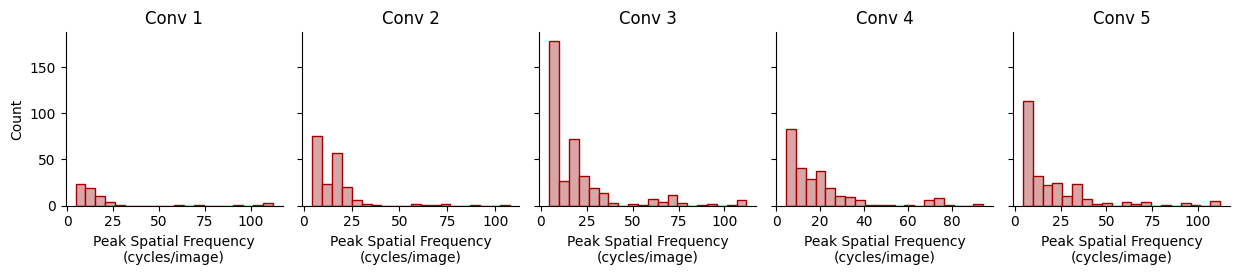

In [ ]:
import os
import pickle

file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_spatial_freq_histograms(results, target_epoch=100, dataset='Toybox-12')

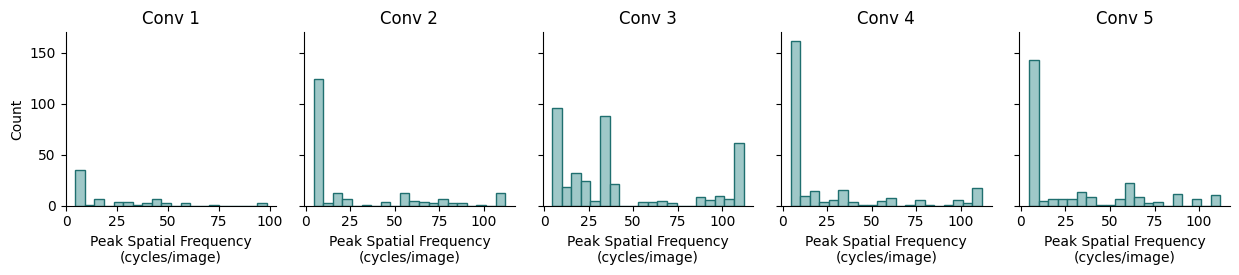

In [ ]:
import os
import pickle

file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_spatial_freq_histograms(results, target_epoch=100, dataset='Toybox-360')

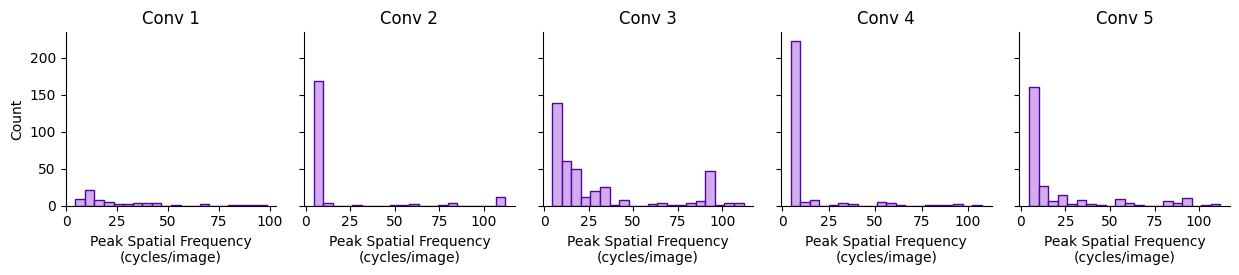

In [ ]:
import os
import pickle

file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_spatial_freq_histograms(results, target_epoch=100, dataset='FaceScrub')

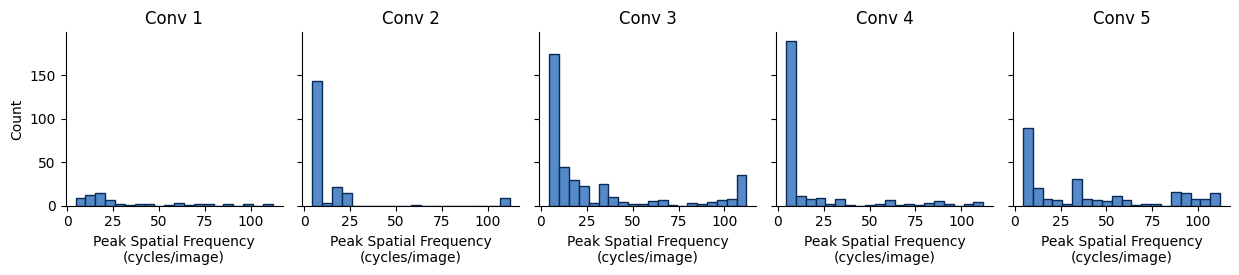

In [ ]:
import os
import pickle

file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_spatial_freq_histograms(results, target_epoch=100, dataset='ImageNet-12')

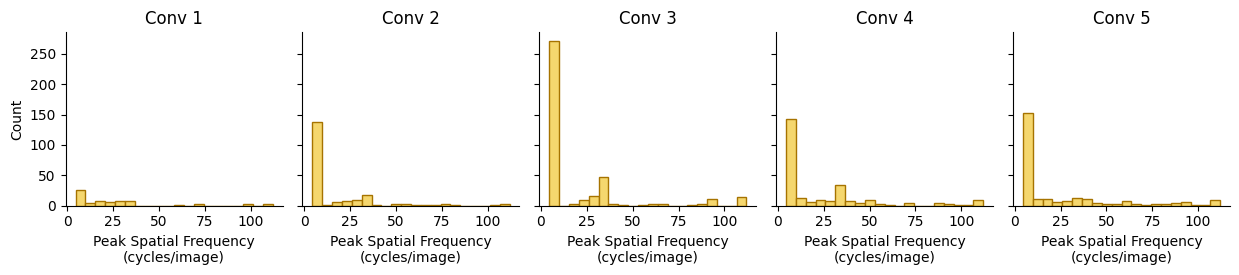

In [ ]:
import os
import pickle

file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_spatial_freq_histograms(results, target_epoch=100, dataset='ImageNet-100')

# Plot histogram evolution

Either combine all layers or choose a representative layer

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Define the color schemes
dataset_colors = {
    'Toybox-12': ("#d8a6a6", "#a00000"),
    'Toybox-360': ("#9fc8c8", "#1f6f6f"),
    'ImageNet-12': ("#5689c8", "#082a54"),
    'FaceScrub': ("#d1adef", "#57039c"),
    'ImageNet-100': ("#f5d76e", "#a67300")
}

def plot_conv5_spatial_freq_evolution(all_epoch_results, dataset='Toybox-12'):
    """
    For the Conv 5 layer (assumed to be "features.10"), plot a histogram
    of spatial frequency preferences at each stage of training (e.g., epochs 20, 40, ...).

    Parameters:
      all_epoch_results: dict
          A dictionary mapping epochs to a dictionary of conv layer names and their spatial frequency lists.
      dataset: str
          Key to select the dataset color scheme.
    """
    conv5_key = "features.10"
    epochs = sorted(all_epoch_results.keys())  # e.g. [20, 40, 60, 80, 100]

    # Select the color pair for the dataset; default to 'Toybox-12' if not found.
    color_light, color_dark = dataset_colors.get(dataset, dataset_colors['Toybox-12'])

    proportions_above_25 = {}

    # Create a subplot for each epoch
    fig, axes = plt.subplots(1, len(epochs), figsize=(2.5 * len(epochs), 3), sharey=True)
    # Ensure axes is iterable.
    if len(epochs) == 1:
        axes = [axes]

    for i, epoch in enumerate(epochs):
        ax = axes[i]
        # Retrieve the spatial frequency data for Conv 5 at the current epoch.
        conv5_data = all_epoch_results[epoch].get(conv5_key, [])
        if len(conv5_data) == 0:
            ax.text(0.5, 0.5, "No Data", ha="center", va="center")
            proportions_above_25[epoch] = float('nan')
        else:
            bins = np.linspace(0, 115, 21)
            ax.hist(conv5_data, bins=bins, color=color_light, edgecolor=color_dark)
            n_filters = len(conv5_data)
            n_above_25 = sum(1 for val in conv5_data if val > 25)
            prop_above_25 = n_above_25 / n_filters
            proportions_above_25[epoch] = prop_above_25

        ax.set_title(f"Epoch {epoch}", fontsize=12)
        ax.set_xlabel("Peak Spatial Frequency\n(cycles/image)")
        if i == 0:
            ax.set_ylabel("Count")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    #fig.suptitle("Conv 1 Spatial Frequency Preferences at Each Training Stage", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return proportions_above_25

def plot_all_conv_spatial_freq_evolution(all_epoch_results, dataset='Toybox-12'):
    """
    Combines the spatial frequency preferences of all convolutional layers and
    plots a histogram for each training stage (e.g., epochs 20, 40, 60, 80, 100)
    in separate subplots.

    Also returns the proportion of filters (for each epoch) whose peak spatial
    frequency exceeds 25 cycles/image, and displays that value on each subplot.

    Parameters
    ----------
    all_epoch_results : dict
        A dictionary mapping epochs to a dictionary of convolutional layer names
        and their spatial frequency lists.
    dataset : str
        Key to select the dataset color scheme.

    Returns
    -------
    proportions_above_25 : dict
        A dictionary of {epoch: proportion_of_filters_above_25}.
    """
    # Define keys corresponding to the convolutional layers.
    conv_layers = ["features.0", "features.3", "features.6", "features.8", "features.10"]
    epochs = sorted(all_epoch_results.keys())  # e.g. [20, 40, 60, 80, 100]

    # Select the color pair for the dataset; default to 'Toybox-12' if not found.
    color_light, color_dark = dataset_colors.get(dataset, dataset_colors['Toybox-12'])

    # Prepare a dict to store proportions of filters above threshold for each epoch
    proportions_above_25 = {}

    # Create a subplot for each training stage.
    fig, axes = plt.subplots(1, len(epochs), figsize=(2.5 * len(epochs), 3), sharey=True)
    if len(epochs) == 1:
        # If there's only one epoch, axes is not an iterable by default
        axes = [axes]

    for i, epoch in enumerate(epochs):
        ax = axes[i]
        ax.set_xlim([0, 115])
        combined_data = []

        # Combine spatial frequency data from all conv layers at this epoch.
        for layer in conv_layers:
            data = all_epoch_results[epoch].get(layer, [])
            combined_data.extend(data)

        if len(combined_data) == 0:
            ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=10)
            proportions_above_25[epoch] = float('nan')
        else:
            # Plot the histogram
            ax.hist(combined_data, bins=20, color=color_light, edgecolor=color_dark)

            # Compute proportion above 25 cycles/image
            n_filters = len(combined_data)
            n_above_25 = sum(1 for val in combined_data if val > 25)
            prop_above_25 = n_above_25 / n_filters
            proportions_above_25[epoch] = prop_above_25

        ax.set_title(f"Epoch {epoch}", fontsize=12)
        ax.set_xlabel("Peak Spatial Frequency\n(cycles/image)")
        if i == 0:
            ax.set_ylabel("Count")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return proportions_above_25

## Spatial frequency evolution of Conv 5

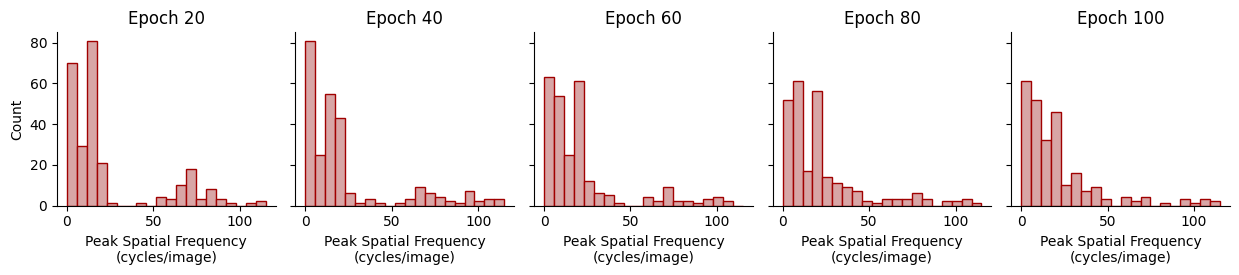

{20: 0.21484375, 40: 0.203125, 60: 0.20703125, 80: 0.2734375, 100: 0.25390625}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv5_spatial_freq_evolution(results, dataset='Toybox-12')

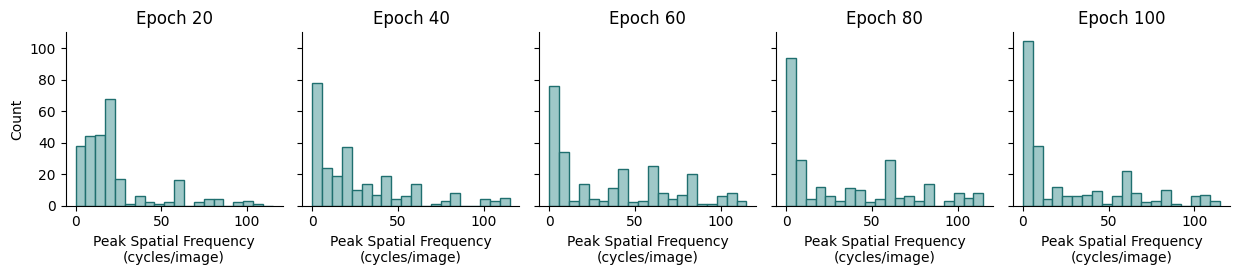

{20: 0.23828125,
 40: 0.3828125,
 60: 0.50390625,
 80: 0.45703125,
 100: 0.37890625}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv5_spatial_freq_evolution(results, dataset='Toybox-360')

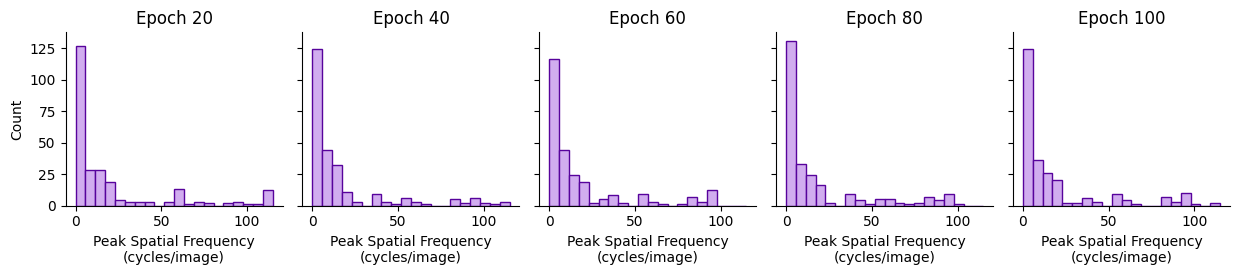

{20: 0.2109375, 40: 0.17578125, 60: 0.20703125, 80: 0.203125, 100: 0.1953125}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv5_spatial_freq_evolution(results, dataset='FaceScrub')

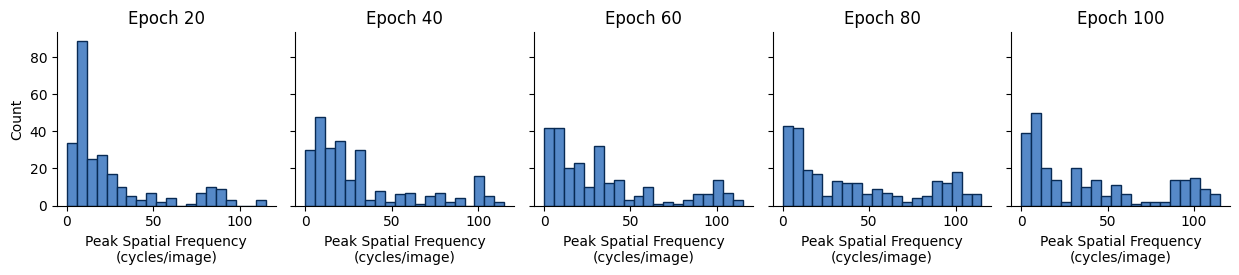

{20: 0.31640625, 40: 0.4375, 60: 0.50390625, 80: 0.52734375, 100: 0.51953125}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv5_spatial_freq_evolution(results, dataset='ImageNet-12')

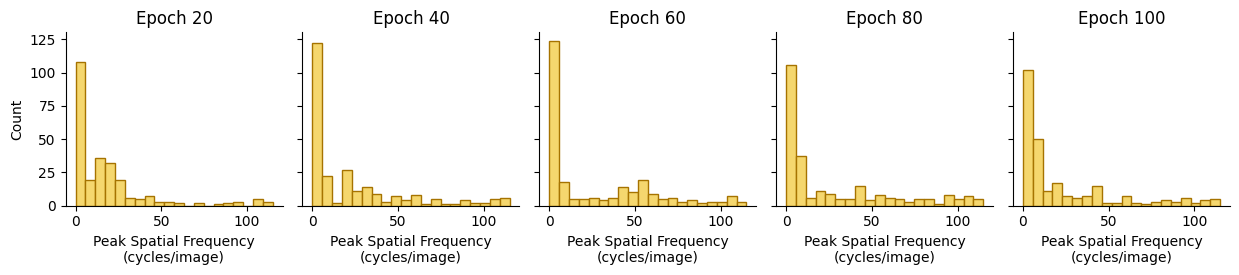

{20: 0.23828125, 40: 0.32421875, 60: 0.40625, 80: 0.375, 100: 0.296875}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv5_spatial_freq_evolution(results, dataset='ImageNet-100')

## Spatial frequency evolution of Conv 1

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv1_spatial_freq_evolution(results, dataset='Toybox-12')

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv1_spatial_freq_evolution(results, dataset='Toybox-360')

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv1_spatial_freq_evolution(results, dataset='FaceScrub')

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv1_spatial_freq_evolution(results, dataset='ImageNet-12')

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv1_spatial_freq_evolution(results, dataset='ImageNet-100')

## Spatial frequency evolution of all layers combined

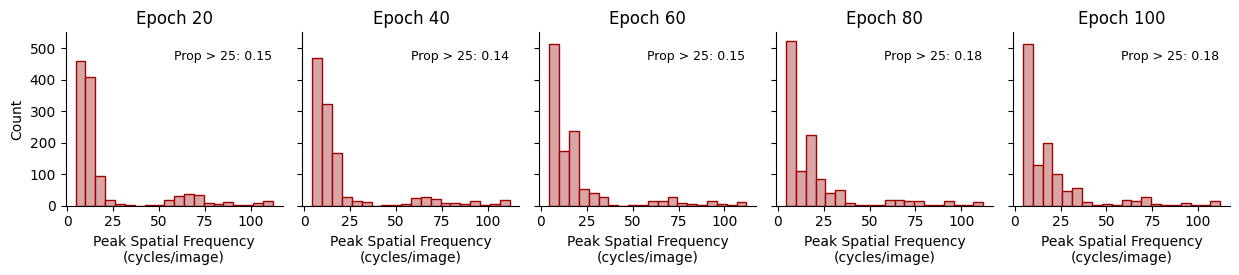

{20: 0.1484375,
 40: 0.14322916666666666,
 60: 0.1501736111111111,
 80: 0.1779513888888889,
 100: 0.18229166666666666}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_all_conv_spatial_freq_evolution(results, dataset='Toybox-12')

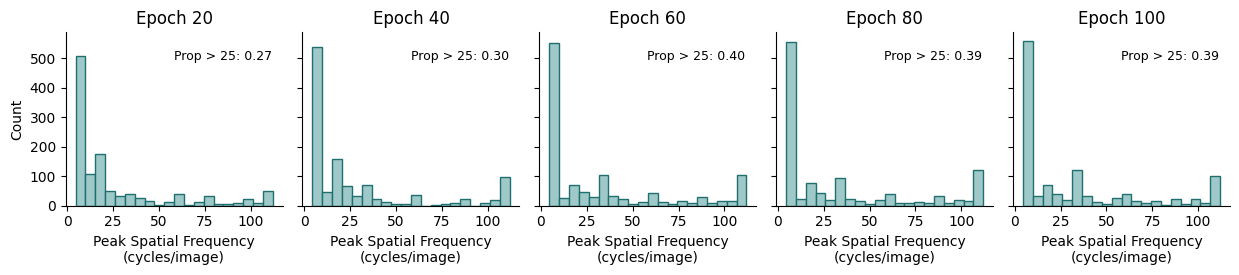

{20: 0.2725694444444444,
 40: 0.2986111111111111,
 60: 0.3967013888888889,
 80: 0.3923611111111111,
 100: 0.3897569444444444}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_all_conv_spatial_freq_evolution(results, dataset='Toybox-360')

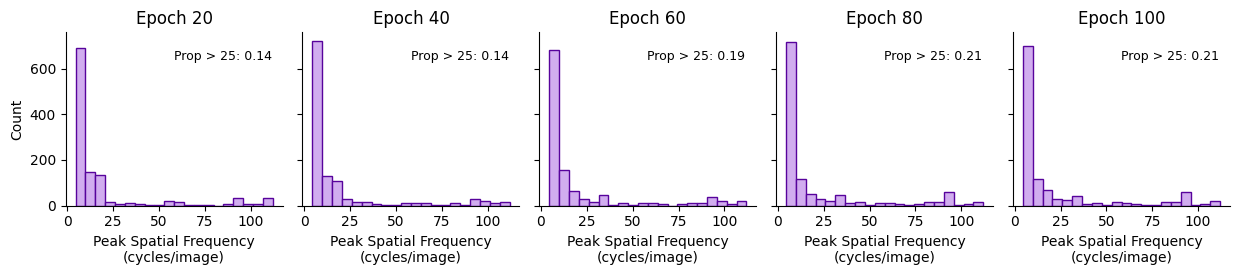

{20: 0.13975694444444445,
 40: 0.14322916666666666,
 60: 0.1892361111111111,
 80: 0.2092013888888889,
 100: 0.2065972222222222}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_all_conv_spatial_freq_evolution(results, dataset='FaceScrub')

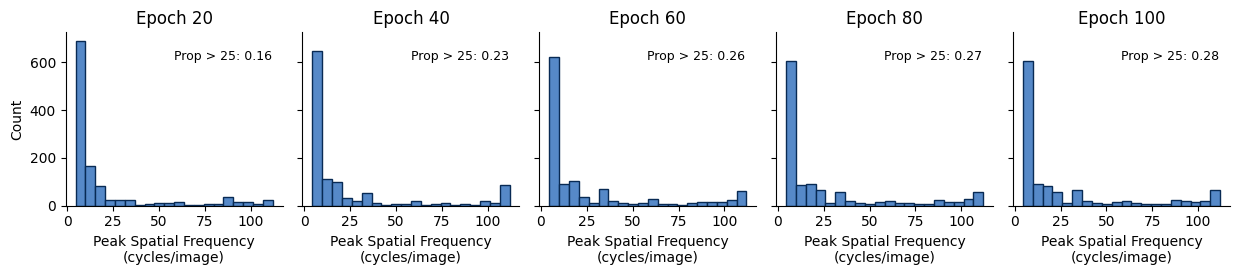

{20: 0.16493055555555555,
 40: 0.22916666666666666,
 60: 0.2630208333333333,
 80: 0.2673611111111111,
 100: 0.2769097222222222}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_all_conv_spatial_freq_evolution(results, dataset='ImageNet-12')

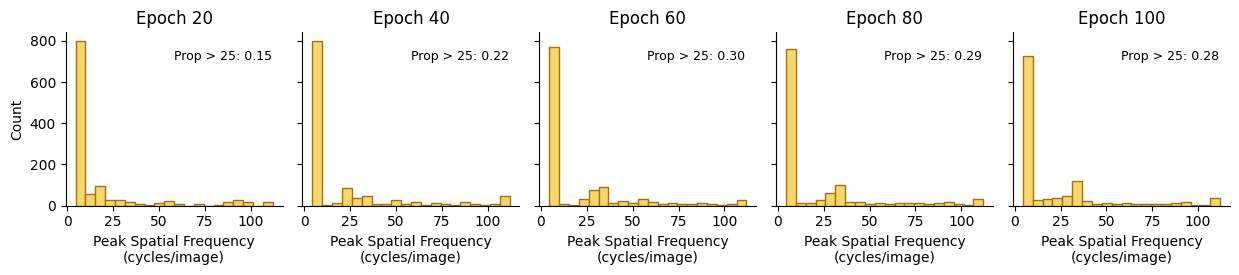

{20: 0.1519097222222222,
 40: 0.2152777777777778,
 60: 0.2977430555555556,
 80: 0.2934027777777778,
 100: 0.2838541666666667}

In [ ]:
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_all_conv_spatial_freq_evolution(results, dataset='ImageNet-100')

# Line plot spatial frequency evolution conv 5

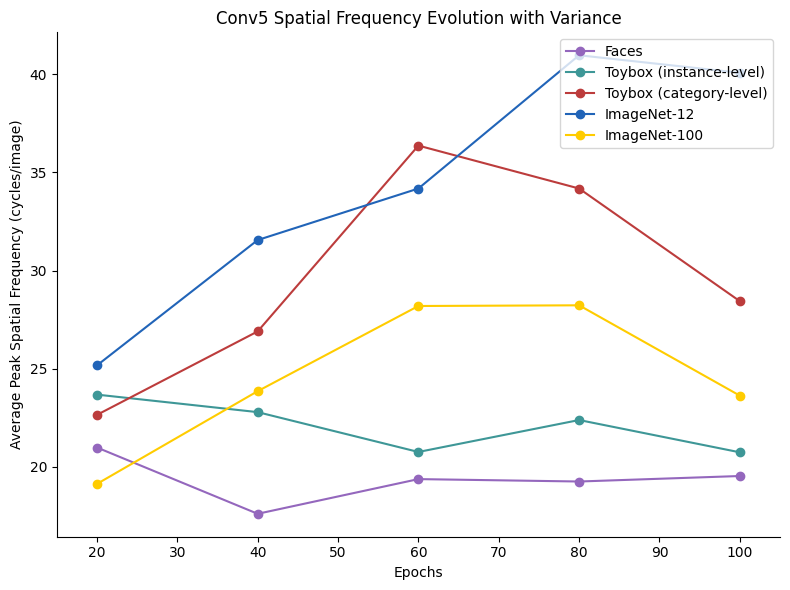

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load your spatial frequency data from pickle files
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl", "rb") as f:
    toybox12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl", "rb") as f:
    toybox360_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl", "rb") as f:
    faces_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl", "rb") as f:
    IN12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl", "rb") as f:
    IN100_results = pickle.load(f)

# Set the key and epochs to use
conv5_key = "features.10"
epochs = [20, 40, 60, 80, 100]

datasets = {
    "Faces": faces_results,
    "Toybox (instance-level)": toybox12_results,
    "Toybox (category-level)": toybox360_results,
    "ImageNet-12": IN12_results,
    "ImageNet-100": IN100_results
}
colors = {
    "Toybox (category-level)": "#bc3c3c",
    "Toybox (instance-level)": "#3e9797",
    "Faces": "#9467bd",
    "ImageNet-12": "#2164b8",
    "ImageNet-100": "#ffcc00"
}

# Plot setup
plt.figure(figsize=(8, 6))

for name, results in datasets.items():
    means, stds = [], []

    for epoch in epochs:
        data = results[epoch].get(conv5_key, [])
        if len(data) > 0:
            data = np.array(data)
            means.append(np.mean(data))
            stds.append(np.std(data))
        else:
            means.append(np.nan)
            stds.append(0)

    means = np.array(means)
    #stds = np.array(stds)

    color = colors[name]
    plt.plot(epochs, means, marker='o', linestyle='-', color=color, label=name)
    #plt.fill_between(epochs, means - stds, means + stds, alpha=0.2, color=color)

# Plot details
plt.xlabel("Epochs")
plt.ylabel("Average Peak Spatial Frequency (cycles/image)")
plt.title("Conv5 Spatial Frequency Evolution with Variance")
plt.legend(loc='upper right')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim([min(epochs) - 5, max(epochs) + 5])
plt.tight_layout()
plt.show()

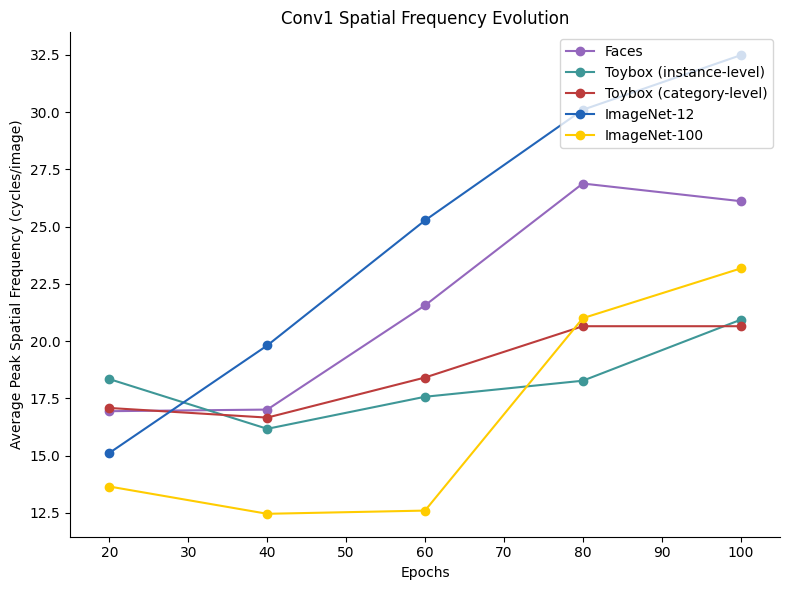

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load your spatial frequency data from pickle files
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl", "rb") as f:
    toybox12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl", "rb") as f:
    toybox360_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl", "rb") as f:
    faces_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl", "rb") as f:
    IN12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl", "rb") as f:
    IN100_results = pickle.load(f)

# Set the key and epochs to use
conv1_key = "features.0"
epochs = [20, 40, 60, 80, 100]

datasets = {
    "Faces": faces_results,
    "Toybox (instance-level)": toybox12_results,
    "Toybox (category-level)": toybox360_results,
    "ImageNet-12": IN12_results,
    "ImageNet-100": IN100_results
}
colors = {
    "Toybox (category-level)": "#bc3c3c",
    "Toybox (instance-level)": "#3e9797",
    "Faces": "#9467bd",
    "ImageNet-12": "#2164b8",
    "ImageNet-100": "#ffcc00"
}

# Plot setup
plt.figure(figsize=(8, 6))

for name, results in datasets.items():
    means, stds = [], []

    for epoch in epochs:
        data = results[epoch].get(conv1_key, [])
        if len(data) > 0:
            data = np.array(data)
            means.append(np.mean(data))
            stds.append(np.std(data))
        else:
            means.append(np.nan)
            stds.append(0)

    means = np.array(means)
    #stds = np.array(stds)

    color = colors[name]
    plt.plot(epochs, means, marker='o', linestyle='-', color=color, label=name)
    #plt.fill_between(epochs, means - stds, means + stds, alpha=0.2, color=color)

# Plot details
plt.xlabel("Epochs")
plt.ylabel("Average Peak Spatial Frequency (cycles/image)")
plt.title("Conv1 Spatial Frequency Evolution")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='upper right')
plt.xlim([min(epochs) - 5, max(epochs) + 5])
plt.tight_layout()
plt.show()

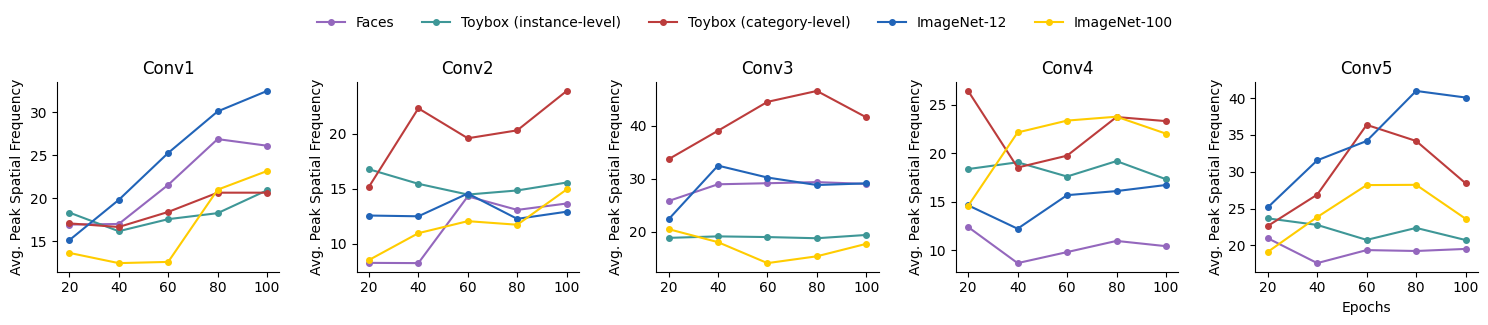

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load your spatial frequency data from pickle files
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl", "rb") as f:
    toybox12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl", "rb") as f:
    toybox360_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl", "rb") as f:
    faces_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl", "rb") as f:
    IN12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl", "rb") as f:
    IN100_results = pickle.load(f)


# Define convolution layer keys and corresponding titles
conv_keys = ["features.0", "features.3", "features.6", "features.8", "features.10"]
conv_titles = ["Conv1", "Conv2", "Conv3", "Conv4", "Conv5"]
epochs = [20, 40, 60, 80, 100]

datasets = {
    "Faces": faces_results,
    "Toybox (instance-level)": toybox12_results,
    "Toybox (category-level)": toybox360_results,
    "ImageNet-12": IN12_results,
    "ImageNet-100": IN100_results
}
colors = {
    "Toybox (category-level)": "#bc3c3c",
    "Toybox (instance-level)": "#3e9797",
    "Faces": "#9467bd",
    "ImageNet-12": "#2164b8",
    "ImageNet-100": "#ffcc00"
}

# Create 5 subplots (one for each conv layer)
fig, axes = plt.subplots(1, 5, sharex=True, figsize=(15, 3))

for i, (conv_key, title) in enumerate(zip(conv_keys, conv_titles)):
    ax = axes[i]
    for name, results in datasets.items():
        means, stds = [], []
        for epoch in epochs:
            data = results[epoch].get(conv_key, [])
            if len(data) > 0:
                data = np.array(data)
                means.append(np.mean(data))
                stds.append(np.std(data))
            else:
                means.append(np.nan)
                stds.append(0)
        means = np.array(means)
        color = colors[name]
        ax.plot(epochs, means, marker='o', linestyle='-', color=color, label=name, markersize=4)
        # Uncomment the next line if you want to show error bands:
        # ax.fill_between(epochs, means - stds, means + stds, alpha=0.2, color=color)

    ax.set_title(title)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([min(epochs) - 5, max(epochs) + 5])
    ax.set_ylabel("Avg. Peak Spatial Frequency")
    # Only the bottom subplot gets the x-axis label
    if i == len(conv_keys) - 1:
        ax.set_xlabel("Epochs")

# Create a shared legend above all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5, frameon=False, bbox_to_anchor=(0.5, 1.09))

# Overall title and layout adjustments
#fig.suptitle("Spatial Frequency Evolution Across Conv Layers", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

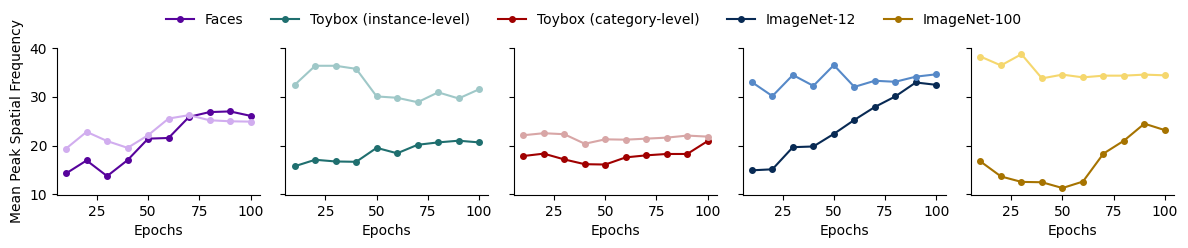

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load your spatial frequency data from pickle files
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl", "rb") as f:
    toybox12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl", "rb") as f:
    toybox360_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl", "rb") as f:
    faces_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl", "rb") as f:
    IN12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl", "rb") as f:
    IN100_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_clear_spatial_frequencies.pkl", "rb") as f:
    toybox12_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_clear_spatial_frequencies.pkl", "rb") as f:
    toybox360_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_clear_spatial_frequencies.pkl", "rb") as f:
    faces_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_clear_spatial_frequencies.pkl", "rb") as f:
    IN12_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_clear_spatial_frequencies.pkl", "rb") as f:
    IN100_clear_results = pickle.load(f)

# Define the datasets information.
# Each dictionary now includes keys for the mean values and the corresponding standard deviations.
datasets_info = [
    {"label": "Faces",
     "dark": "#57039c",
     "light": "#d1adef",
     "values": faces_results,
     #"std": faces_rf_std,
     "clear": faces_clear_results},
     #"std_clear": faces_rf_std_clear,
     #"blur": faces_rf_evolution_blur},
     #"std_blur": faces_rf_std_blur},
    {"label": "Toybox (instance-level)",
     "dark": "#1f6f6f",
     "light": "#9fc8c8",
     "values": toybox360_results,
     #"std": toybox360_rf_std,
     "clear": toybox360_clear_results},
     #"std_clear": toybox360_rf_std_clear,
     #"blur": toybox360_rf_evolution_blur},
     #"std_blur": toybox360_rf_std_blur},
    {"label": "Toybox (category-level)",
     "dark": "#a00000",
     "light": "#d8a6a6",
     "values": toybox12_results,
     #"std": toybox12_rf_std,
     "clear": toybox12_clear_results},
     #"std_clear": toybox12_rf_std_clear,
     #"blur": toybox12_rf_evolution_blur},
     #"std_blur": toybox12_rf_std_blur},
    {"label": "ImageNet-12",
     "dark": "#082a54",
     "light": "#5689c8",
     "values": IN12_results,
     #"std": IN12_rf_std,
     "clear": IN12_clear_results},
     #"std_clear": IN12_rf_std_clear,
     #"blur": IN12_rf_evolution_blur},
     #"std_blur": IN12_rf_std_blur},
    {"label": "ImageNet-100",
     "dark": "#a67300",
     "light": "#f5d76e",
     "values": IN100_results,
     #"std": IN100_rf_std,
     "clear": IN100_clear_results},
     #"std_clear": IN100_rf_std_clear,
     #"blur": IN100_rf_evolution_blur},
     #"std_blur": IN100_rf_std_blur},
]

# Define the epochs corresponding to your values.
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create a figure with 5 subplots arranged horizontally.
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 2.5), sharey=True)

for ax, ds in zip(axes, datasets_info):
    means, clear_means = [], []
    for epoch in epochs:
        data = ds["values"][epoch].get("features.0", [])
        clear_data = ds["clear"][epoch].get("features.0", [])
        if len(data) > 0:
            data = np.array(data)
            means.append(np.mean(data))
        else:
            means.append(np.nan)
        if len(clear_data) > 0:
            clear_data = np.array(clear_data)
            clear_means.append(np.mean(clear_data))
        else:
            clear_means.append(np.nan)
    ax.plot(epochs, means, marker='o', linestyle='-', color=ds["dark"], label=ds["label"], markersize=4)
    ax.plot(epochs, clear_means, marker='o', linestyle='-', color=ds["light"], markersize=4)
    if ax == axes[0]:
        ax.set_ylabel("Mean Peak Spatial Frequency")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Epochs")

fig.legend([ax.lines[0] for ax in axes],
           [ds["label"] for ds in datasets_info],
           loc="upper center", ncol=5, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

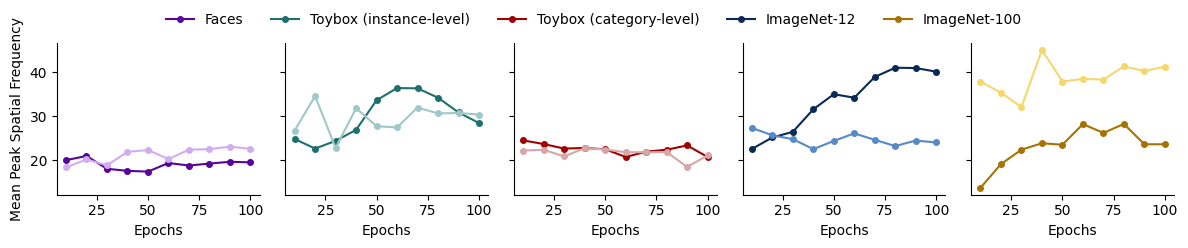

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load your spatial frequency data from pickle files
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl", "rb") as f:
    toybox12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_spatial_frequencies.pkl", "rb") as f:
    toybox360_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_spatial_frequencies.pkl", "rb") as f:
    faces_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_spatial_frequencies.pkl", "rb") as f:
    IN12_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_spatial_frequencies.pkl", "rb") as f:
    IN100_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_clear_spatial_frequencies.pkl", "rb") as f:
    toybox12_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox360_clear_spatial_frequencies.pkl", "rb") as f:
    toybox360_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/face_clear_spatial_frequencies.pkl", "rb") as f:
    faces_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN12_clear_spatial_frequencies.pkl", "rb") as f:
    IN12_clear_results = pickle.load(f)
with open("/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/IN100_clear_spatial_frequencies.pkl", "rb") as f:
    IN100_clear_results = pickle.load(f)

# Define the datasets information.
# Each dictionary now includes keys for the mean values and the corresponding standard deviations.
datasets_info = [
    {"label": "Faces",
     "dark": "#57039c",
     "light": "#d1adef",
     "values": faces_results,
     #"std": faces_rf_std,
     "clear": faces_clear_results},
     #"std_clear": faces_rf_std_clear,
     #"blur": faces_rf_evolution_blur},
     #"std_blur": faces_rf_std_blur},
    {"label": "Toybox (instance-level)",
     "dark": "#1f6f6f",
     "light": "#9fc8c8",
     "values": toybox360_results,
     #"std": toybox360_rf_std,
     "clear": toybox360_clear_results},
     #"std_clear": toybox360_rf_std_clear,
     #"blur": toybox360_rf_evolution_blur},
     #"std_blur": toybox360_rf_std_blur},
    {"label": "Toybox (category-level)",
     "dark": "#a00000",
     "light": "#d8a6a6",
     "values": toybox12_results,
     #"std": toybox12_rf_std,
     "clear": toybox12_clear_results},
     #"std_clear": toybox12_rf_std_clear,
     #"blur": toybox12_rf_evolution_blur},
     #"std_blur": toybox12_rf_std_blur},
    {"label": "ImageNet-12",
     "dark": "#082a54",
     "light": "#5689c8",
     "values": IN12_results,
     #"std": IN12_rf_std,
     "clear": IN12_clear_results},
     #"std_clear": IN12_rf_std_clear,
     #"blur": IN12_rf_evolution_blur},
     #"std_blur": IN12_rf_std_blur},
    {"label": "ImageNet-100",
     "dark": "#a67300",
     "light": "#f5d76e",
     "values": IN100_results,
     #"std": IN100_rf_std,
     "clear": IN100_clear_results},
     #"std_clear": IN100_rf_std_clear,
     #"blur": IN100_rf_evolution_blur},
     #"std_blur": IN100_rf_std_blur},
]

# Define the epochs corresponding to your values.
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create a figure with 5 subplots arranged horizontally.
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 2.5), sharey=True)

for ax, ds in zip(axes, datasets_info):
    means, clear_means = [], []
    for epoch in epochs:
        data = ds["values"][epoch].get("features.10", [])
        clear_data = ds["clear"][epoch].get("features.10", [])
        if len(data) > 0:
            data = np.array(data)
            means.append(np.mean(data))
        else:
            means.append(np.nan)
        if len(clear_data) > 0:
            clear_data = np.array(clear_data)
            clear_means.append(np.mean(clear_data))
        else:
            clear_means.append(np.nan)
    ax.plot(epochs, means, marker='o', linestyle='-', color=ds["dark"], label=ds["label"], markersize=4)
    ax.plot(epochs, clear_means, marker='o', linestyle='-', color=ds["light"], markersize=4)
    if ax == axes[0]:
        ax.set_ylabel("Mean Peak Spatial Frequency")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Epochs")

fig.legend([ax.lines[0] for ax in axes],
           [ds["label"] for ds in datasets_info],
           loc="upper center", ncol=5, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Spectogram

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_conv5_spectrogram(all_epoch_results, dataset='Toybox-12'):
    """
    For the Conv 5 layer (assumed to be "features.10"), compute histograms of spatial frequency
    preferences at each training epoch and plot a spectrogram where:
      - x-axis: epoch
      - y-axis: spatial frequency (cycles/image)
      - color: histogram count (height)

    Parameters:
      all_epoch_results: dict
          Dictionary mapping epochs (e.g., 20, 40, 60, 80, 100) to a dictionary of layer keys and
          their corresponding spatial frequency lists.
      dataset: str
          Key to select the dataset color scheme (not used for the colormap but can be used to select
          a preferred colormap if desired).
    """
    conv5_key = "features.10"
    epochs = sorted(all_epoch_results.keys())  # e.g. [20, 40, 60, 80, 100]

    # Define histogram bins (same as in your histogram code)
    bins = np.linspace(0, 115, 21)  # 20 bins spanning 0 to 115 cycles/image

    # Build a matrix where each row corresponds to a bin and each column to an epoch.
    # For each epoch, compute the histogram counts.
    hist_matrix = []
    for epoch in epochs:
        conv5_data = all_epoch_results[epoch].get(conv5_key, [])
        if len(conv5_data) == 0:
            hist_counts = np.zeros(len(bins)-1)
        else:
            hist_counts, _ = np.histogram(conv5_data, bins=bins)
        hist_matrix.append(hist_counts)

    # Convert to a 2D numpy array and transpose so that rows are spatial frequency bins,
    # and columns are epochs.
    hist_matrix = np.array(hist_matrix).T

    # Determine the extent of the image:
    # x-axis from min to max epoch, y-axis from bins[0] to bins[-1]
    extent = [min(epochs), max(epochs), bins[0], bins[-1]]

    plt.figure(figsize=(8,6))
    # Use a colormap (e.g. 'viridis') where color indicates count.
    plt.imshow(hist_matrix, aspect='auto', origin='lower', extent=extent, cmap='viridis')
    plt.xlabel("Epoch")
    plt.ylabel("Peak Spatial Frequency (cycles/image)")
    plt.title("Conv 5 Spatial Frequency Spectrogram")
    plt.colorbar(label="Histogram Count")
    plt.tight_layout()
    plt.show()

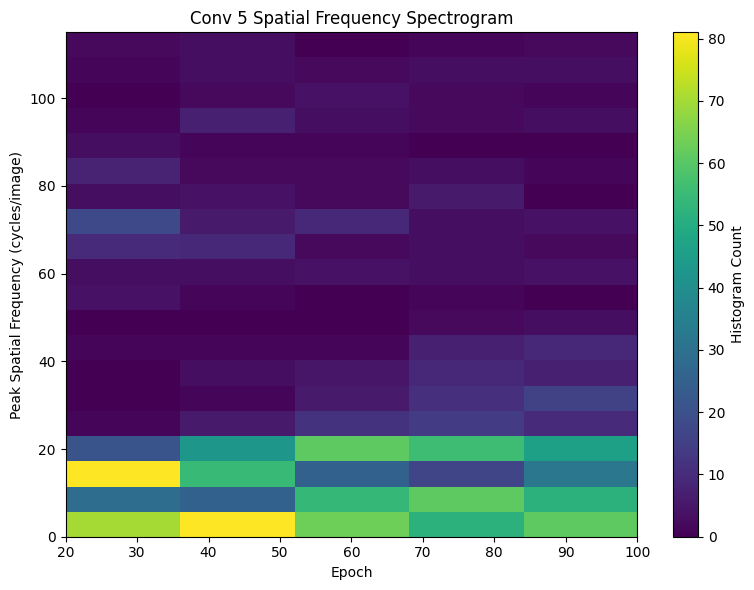

In [ ]:
import os
import pickle

file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/spatial_frequencies/toybox12_spatial_frequencies.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)

plot_conv5_spectrogram(results, dataset='Toybox-12')